# Get gas station prices by location

In [1]:
import requests
import xml.etree.ElementTree as et

## Get gas stations in Mexico

In [2]:
# xml file information
url = "https://bit.ly/2V1Z3sm"

# Load xml file in memory
r = requests.get(url,allow_redirects=True)

In [3]:
# Using element tree to handle xml file
root = et.fromstring(r.content)
print(root)

<Element 'places' at 0x0000029862EE5040>


## Extracting attributes function 1

In [4]:
def place_info(idx: int):
    """
    Create a dictionary list from xml file with attributes.\n
    [place_id, name, cree_id, latitude, longitude]
    """
    place_dict = {}
    # Get place_id
    place_dict["place_id"] = int(root[idx].attrib.get("place_id"))

    # Get name station
    place_dict["name"] = root[idx][0].text

    # Get cree_id
    place_dict["cree_id"] = root[idx][1].text

    # Get location coordinates
    place_dict["latitude"] = float(root[idx][2][1].text)
    place_dict["longitude"] = float(root[idx][2][0].text)
    
    return place_dict

## Creating pandas dataframe for places

In [5]:
places_list = []
for i in range(len(root)):
    places_list.append(place_info(i))

In [6]:
import pandas as pd
import numpy as np

places = pd.DataFrame(places_list)
places.set_index("place_id",inplace=True)
places.replace(0, np.nan, inplace=True)
places

,name,cree_id,latitude,longitude
place_id,,,,
2039,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,32.47641,-116.92140
2040,"LAS MEJORES ESTACIONES, S.A DE C.V",PL/902/EXP/ES/2015,20.30370,-99.74484
2041,"DIAZ GAS, S.A. DE C.V.",PL/760/EXP/ES/2015,31.71947,-106.45140
2042,"COMBU-EXPRESS, S.A. DE C.V.",PL/825/EXP/ES/2015,20.71413,-103.30420
2043,"PETROMAX, S.A. DE C.V.",PL/585/EXP/ES/2015,26.03787,-98.29977
...,...,...,...,...
27758,SUMINISTRO DE COMBUSTIBLES EL SEIS S. DE R.L. ...,PL/23961/EXP/ES/2022,20.88375,-102.70250
27759,GASOLINERA SACSALUM SA DE CV,PL/23960/EXP/ES/2022,16.32370,-91.97680
27764,"AEROPUERTO INTERNACIONAL FELIPE ANGELES, SOCIE...",PL/23974/EXP/ES/2022,19.72579,-99.03263


## Fix coordinates

Coordinates system consist in two values, latitude and longitude.

latitude domain --> [-90, 90]

longitude domain --> [-180, 180]

For Mexico the coordinates ranges from:
Latitude [14, 34]
Longitude [-116, -86]

![Coordinates in Mexico](images\mapa-mexico-coordenadas-geograficas.jpg)

### Exploring max and min values
In following sorted data we can see some issues in coordinates:

1. Station with place_id = 23393 have not valid coordinates (is not in domain) and the values does not have sense.
2. Latitude domain is [-90,90], the last 4 stations does not have latitude in this domain, so we suspect this value is longitude and not latitude.

In [7]:
places[["latitude","longitude"]].dropna().sort_values(by=["latitude","longitude"],ascending=False)

,latitude,longitude
place_id,,
23393,2272.49000,355773.10000
9351,32.71629,-114.73260
9675,32.67113,-115.40400
3909,32.66928,-115.39360
7740,32.66899,-115.42610
...,...,...
2415,14.67243,-92.15979
7146,-98.85688,19.35144
5852,-99.02986,19.38820


### Drop outlier
Coordinates system does not have sense and we can't see it in a geographic map, so, we will drop it.

In [8]:
places.loc[23393]

name         INMOBILIARIA HOTELA S.A. DE C.V.
cree_id                  PL/20670/EXP/ES/2017
latitude                              2272.49
longitude                            355773.1
Name: 23393, dtype: object

In [9]:
places.drop(23393,inplace=True)

### Change latitude and longitude

We change latitud to longitude and longitude to latitude.

In [10]:
# Fix location coordinates
for index in places.index:
    # latitude domain [-90,90]
    # longitude domain [-180,180]
    if places.loc[index,"latitude"] > 90 or places.loc[index,"latitude"] < -90:
        longitud = places.loc[index, "latitude"].copy()
        latitud = places.loc[index, "longitude"].copy()
        
        places.loc[index, "longitude"] = longitud
        places.loc[index, "latitude"] = latitud

### First Boxplot

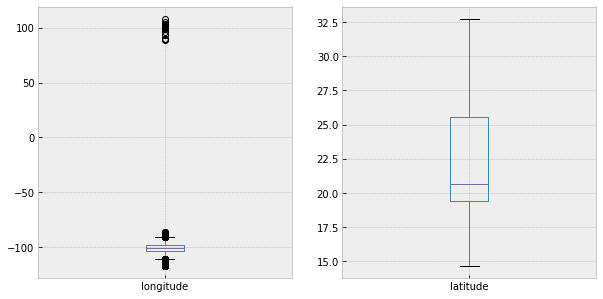

In [11]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.style.use("bmh")
plt.subplot(1,2,1)
places[["longitude"]].boxplot()
plt.subplot(1,2,2)
places[["latitude"]].boxplot()
plt.show()

### Fixing coordinates
In previous boxplot we can see some values for longitude that are not valid because longitude values of aproximately 100 are in Myanmar or Tailand. We suspect that this values are in fact negative values because that makes sense.

In [12]:
places["longitude"][places["longitude"] > 50] = places["longitude"][places["longitude"] > 50].mul(-1)

C:\Users\chccr\AppData\Local\Temp\ipykernel_8356\3799122698.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  places["longitude"][places["longitude"] > 50] = places["longitude"][places["longitude"] > 50].mul(-1)


### Second Boxplot

Finally we can se the distribution for all gas stations coordinates. This values are in valid ranges.

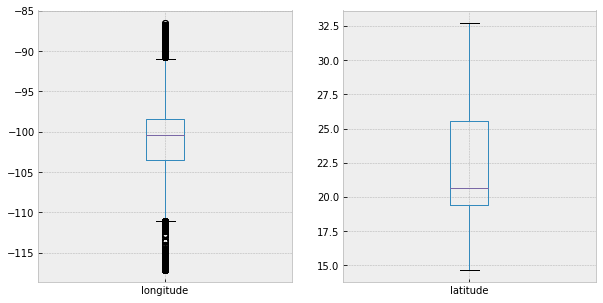

In [13]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.style.use("bmh")
plt.subplot(1,2,1)
places[["longitude"]].boxplot()
plt.subplot(1,2,2)
places[["latitude"]].boxplot()
plt.show()

## Get prices for gas stations

In [14]:
url = "https://bit.ly/2JNcTha"
r = requests.get(url, allow_redirects=True)

In [15]:
root = et.fromstring(r.content)
print(root)

<Element 'places' at 0x0000029862EBEE50>


### Extracting attributes function 2

In [16]:
def price_info(idx: int):
    """
    The function extract features from an xml file.
    [regular, premium, diesel]
    """
    place_dict = {}
    # Get place_id
    place_dict["place_id"] = int(root[idx].attrib.get("place_id"))

    for gas_types in root[idx]:
        place_dict[gas_types.get("type")] = float(gas_types.text)
        
    return place_dict

## Creating pandas dataframe for prices

In [17]:
places_list = []
for i in range(len(root)):
    places_list.append(price_info(i))

In [18]:
import numpy as np

prices = pd.DataFrame(places_list)
prices.set_index("place_id",inplace=True)
prices = prices.groupby(prices.index).sum()
prices.replace(0.0,np.nan,inplace=True)
prices

,regular,premium,diesel
place_id,,,
2039,22.49,24.99,21.99
2040,21.25,23.19,23.09
2041,17.28,19.20,NaN
2042,21.79,24.39,23.54
2043,17.79,19.99,NaN
...,...,...,...
27732,22.69,23.79,NaN
27734,21.99,23.85,23.98
27738,20.62,22.11,NaN


## Merge dataframes

In [19]:
df = places.merge(prices,how="left",left_index=True,right_index=True)

# Drop stations with nan location
df.dropna(subset=["latitude","longitude"],inplace=True)
df

,name,cree_id,latitude,longitude,regular,premium,diesel
place_id,,,,,,,
2039,"ESTACION DE SERVICIO CALAFIA, S.A. DE C.V.",PL/658/EXP/ES/2015,32.47641,-116.92140,22.49,24.99,21.99
2040,"LAS MEJORES ESTACIONES, S.A DE C.V",PL/902/EXP/ES/2015,20.30370,-99.74484,21.25,23.19,23.09
2041,"DIAZ GAS, S.A. DE C.V.",PL/760/EXP/ES/2015,31.71947,-106.45140,17.28,19.20,NaN
2042,"COMBU-EXPRESS, S.A. DE C.V.",PL/825/EXP/ES/2015,20.71413,-103.30420,21.79,24.39,23.54
2043,"PETROMAX, S.A. DE C.V.",PL/585/EXP/ES/2015,26.03787,-98.29977,17.79,19.99,NaN
...,...,...,...,...,...,...,...
27758,SUMINISTRO DE COMBUSTIBLES EL SEIS S. DE R.L. ...,PL/23961/EXP/ES/2022,20.88375,-102.70250,NaN,NaN,NaN
27759,GASOLINERA SACSALUM SA DE CV,PL/23960/EXP/ES/2022,16.32370,-91.97680,NaN,NaN,NaN
27764,"AEROPUERTO INTERNACIONAL FELIPE ANGELES, SOCIE...",PL/23974/EXP/ES/2022,19.72579,-99.03263,NaN,NaN,NaN


## Get map locations

### Getting 100 nearest gas stations function 3

In [20]:
import geopy.distance

def distances(latitude: float, longitude: float):
    distances = []
    for idx in df.index:
        distances.append(
            geopy.distance.geodesic(
                (latitude, longitude),
                (df.loc[idx,"latitude"], df.loc[idx,"longitude"])
                ).km
            )
    distances = pd.DataFrame(distances, columns=["distances"])
    distances["place_id"] = df.index
    distances.set_index("place_id",inplace=True)
    distances = distances.sort_values(by="distances").index[1:100]    
    return list(distances)

## Plot map with locations

In [21]:
import folium

center = [25.76698, -100.25718]

map = folium.Map(
    location = [center[0],center[1]],
    zoom_start = 13
    )

distance_index = distances(center[0],center[1])

min_index = df.loc[distance_index,"regular"].idxmin()
max_index = df.loc[distance_index,"regular"].idxmax()

for idx in distance_index:
    if idx == min_index:
        set_color = "green"
    elif idx == max_index:
        set_color = "red"
    else:
        set_color = "blue"

    folium.Marker(
        location=[df.loc[idx,"latitude"], df.loc[idx,"longitude"]],
        popup=df.loc[idx,"name"]+"\nRegular: "+str(df.loc[idx,"regular"])+"\nPremium: "+ \
            str(df.loc[idx,"premium"])+"\nDiesel: "+str(df.loc[idx,"diesel"]),
        icon=folium.Icon(color=set_color)
    ).add_to(map)

map

## Export dataframe

In [43]:
from datetime import datetime
import re

#Creating name of file based in date
date_ex = re.sub("[-]","",str(datetime.today()))
date_ex = re.sub("[ ]","_",date_ex)
date_ex = re.sub("[:]","",date_ex)
date_ex = date_ex[:-7]

df.to_csv("export_files\gas_prices_{}.csv".format(date_ex))